In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import dask
import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
from xhistogram.xarray import histogram

from matplotlib import cm
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

from bbl import *
from osse import *
from canyon_utils import *
from sloped_MITgcm import *

In [3]:
run_dedalus = False # Dedalus only works on login nodes; MITgcm analysis has to work on compute nodes.

In [4]:
# Constant parameters

Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = -5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.; dy = 600.
delta_t = 15.

### Run / load 1D Dedalus simulations

In [5]:
T = 4800*86400
names = ['default', 'f=0', 'Pr=230']

bbl_runs = {
    'default': {},
    'f=0': {'f': 0.},
    'Pr=230': {'σ': 230.},
    'theta=0': {'θ': 0.}
}
bbl_output = {}

for name, kwargs in bbl_runs.items():
    path = f"../../data/dedalus/transient/BBTRE-{name}_{T}.nc"

    if run_dedalus:
        from bbl import *
        bbl = bbl_exp_spinup(T=T, dt=T/100., **kwargs)
        bbl_output[name] = bbl_to_ds(bbl)
        bbl_output[name].to_netcdf(path)
        
    else:
        pathstr = path.split("/")[-1]
        print(f"Loading {pathstr}")
        bbl_output[name] = xr.open_dataset(path)

Loading BBTRE-default_414720000.nc
Loading BBTRE-f=0_414720000.nc
Loading BBTRE-Pr=230_414720000.nc
Loading BBTRE-theta=0_414720000.nc


In [6]:
experiments = ["idealized-plane-1D", "idealized-plane-1D-Pr230", "idealized-plane", "idealized-canyon", "idealized-sill", "canyon-tracer"]

data = {}
for exp in experiments:
    data[exp] = xr.open_dataset(f"../../data/BBTRE-physics/buoyancy_{exp}.nc")
    data[exp] = data[exp].sel(Z=data[exp]['Z'][:-1])
    data[exp].attrs['H'] = data[exp]['Depth'].max(skipna=True).values

In [9]:
ds = data["idealized-canyon"]

(-0.1, 0.1)

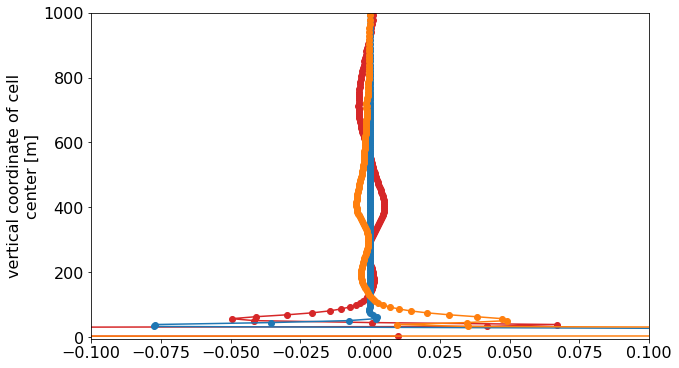

In [7]:
ds = data["idealized-plane"]
(-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 1000])
plt.xlim(-1e-1, 1e-1)

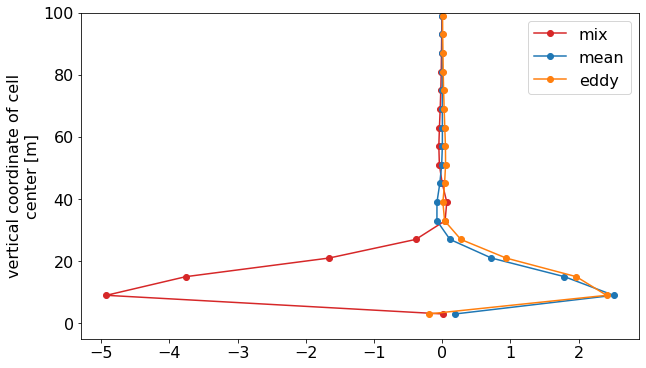

In [20]:
ds = data["idealized-plane"]
(-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 100])
plt.legend()

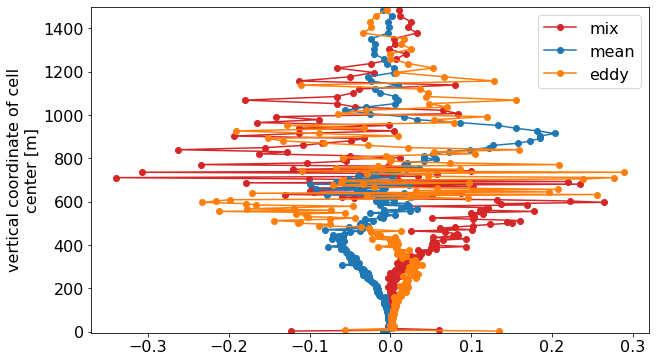

In [21]:
ds = data["canyon-tracer"]
(-(ds["diff_tendency_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C3", marker="o", label="mix")
(-(ds["conv_adv_flux_anom_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C0", marker="o", label="mean")
(-(ds["conv_vert_adv_flux_TH"]/ds['drF']).diff(dim="Z")/ds['drF']).plot(y="Z", c="C1", marker="o", label="eddy")
#plt.ylim([-5, 100])
#data["idealized-plane"]["conv_adv_flux_anom_TH"].diff(dim="Z").plot(y="Z", marker="o")
plt.ylim([-5, 1500])
plt.legend()

#### Plotting

idealized-plane-1D
idealized-plane-1D-Pr230
idealized-plane
idealized-canyon
idealized-sill
canyon-tracer


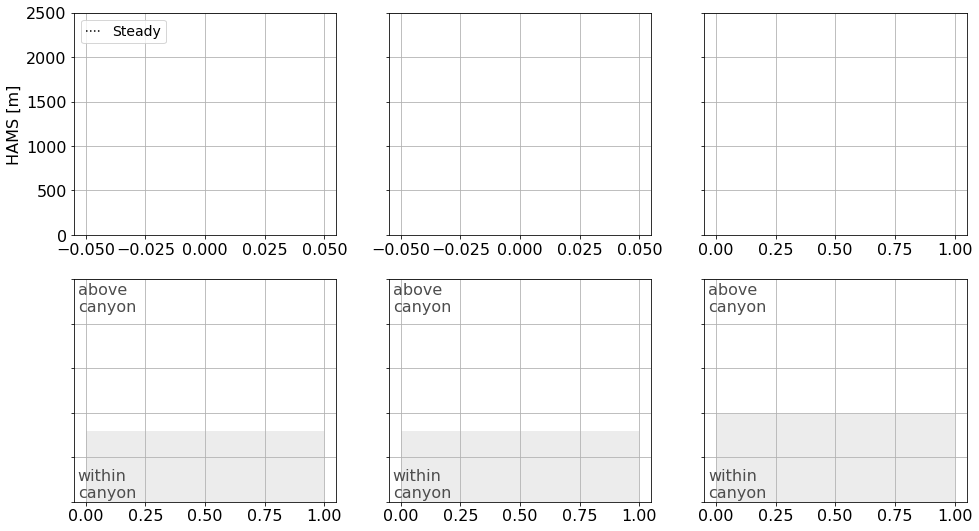

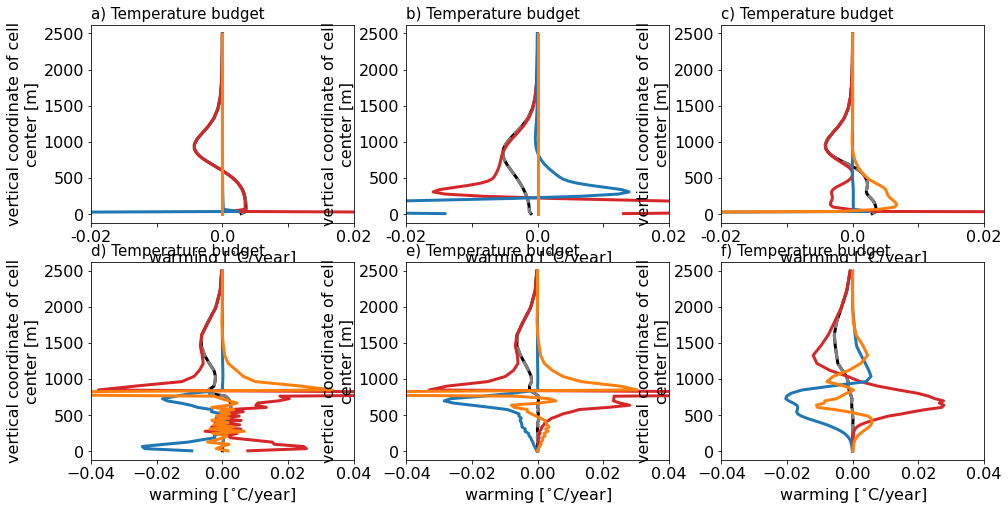

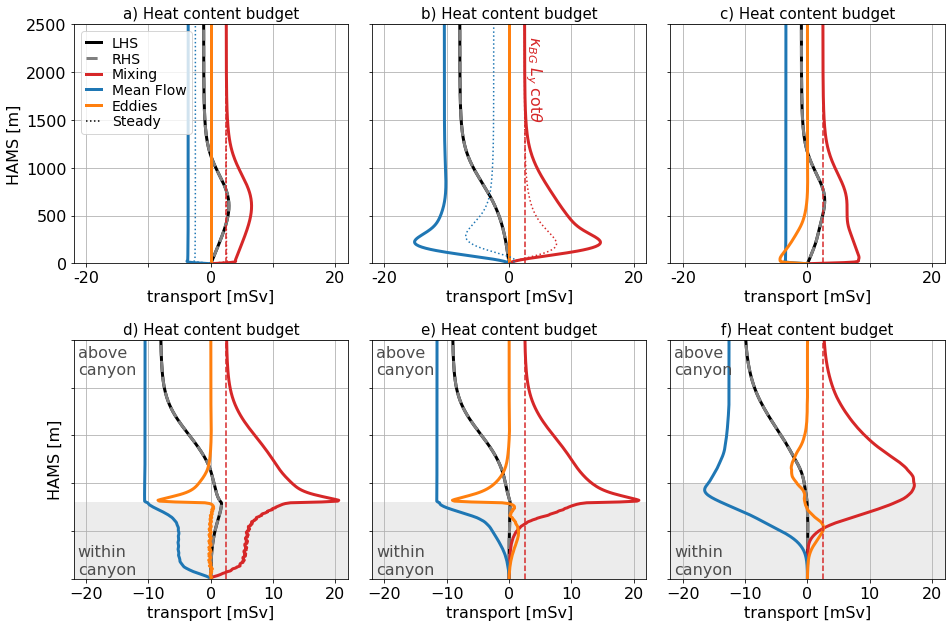

In [33]:
cmap = truncate_colormap(cm.get_cmap('pink'),0.1,1.)

nexp = len(experiments)
fig1, axes1 = plt.subplots(2, (nexp+1)//2, figsize=(16,9))
fig2, axes2 = plt.subplots(2, (nexp+1)//2, figsize=(16,8))
fig3, axes3 = plt.subplots(2, (nexp+1)//2, figsize=(13.5,9))

plabels=["a)", "b)", "c)", "d)", "e)", "f)"]

longnames = {
    'canyon-tracer': "BBTRE canyon",
    'idealized-sill': "Canyon & sill",
    'idealized-canyon': "Gaussian canyon",
    'idealized-plane': "Planar slope",
    'idealized-plane-1D': "Planar slope (1D)",
    'idealized-plane-1D-Pr230': r"Planar slope (1D, $\sigma = 230$)"
}

# labels = {
#     "total_tendency_TH_truth": r"$\partial_{t} \langle T \rangle$",
#     "total_tendency_TH": r"$\sum$ RHS",
#     "diff_tendency_TH": r"$\partial_{z} \langle \kappa \partial_{z} T \rangle$",
#     "conv_adv_flux_anom_TH": r"$-\langle u \rangle \Gamma \sin{\theta}$",
#     "conv_vert_adv_flux_TH": r"$-\partial_{z} \langle w T' \rangle$"
# }

labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Mixing",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_flux_TH": "Eddies"
}

# int_labels = {
#     "total_tendency_TH_truth": r"$\partial_{t} \, \dfrac{\int_{0}^{z}\, \langle T \rangle \; ds}{\Gamma \sin{\theta}} \; L_{y}$",
#     "total_tendency_TH": r"$\sum$ RHS",
#     "diff_tendency_TH": r"$\dfrac{ \langle \kappa \partial_{z} T \rangle}{\Gamma \sin{\theta}}\; L_{y}$",
#     "conv_adv_flux_anom_TH": r"$-\psi\; L_{y}$",
#     "conv_vert_adv_flux_TH": r"$-\dfrac{\langle w T' \rangle}{\Gamma \sin{\theta}}\; L_{y}$"
# }

int_labels = {
    "total_tendency_TH_truth": "LHS",
    "total_tendency_TH": "RHS",
    "diff_tendency_TH": "Mixing",
    "conv_adv_flux_anom_TH": "Mean Flow",
    "conv_vert_adv_flux_TH": "Eddies"
}

for i, (k,v) in enumerate(data.items()):
    print(k, end="\n")

    Lx, Ly = v.XC.size*dx, v.YC.size*dy
    Ly_ref = 60.e3
    cint = k0*Γ*np.cos(θ)*Ly*Lx
    cbot = k1*Γ*np.cos(θ)*Ly*Lx

    linecolors = ["k", "grey", "C3", "C0", "C1"]
    for ii, var in enumerate(labels.keys()):
        linestyle='-'; lw = 3;
        if var=="total_tendency_TH": linestyle="--"; lw=3;
        #v[f"{var}_restratification"].plot(ax=axes1.flatten()[i], y='Zl', color=linecolors[ii], label=labels[var], linestyle=linestyle, lw=lw)
        v[f"{var}_K-per-year"].plot(ax=axes2.flatten()[i], y='Z_coarse', color=linecolors[ii], label=labels[var], linestyle=linestyle, lw=lw)
        v[f"{var}_cumint_mSv"].plot(ax=axes3.flatten()[i], y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyle, lw=lw)

    axes2.flatten()[i].set_xlabel(r"warming [$^{\circ}$C/year]")
    axes2.flatten()[i].set_title(f"{plabels[i]} Temperature budget", fontsize=15, loc="left")
    
    axes3.flatten()[i].axvline(cint/(Γ*np.sin(θ)*Lx*Ly)*(Ly_ref*1e-3), linestyle='--', color='C3')
    axes3.flatten()[i].set_xlabel("transport [mSv]")
    axes3.flatten()[i].set_title(f"{plabels[i]} Heat content budget", fontsize=15)
    if i==1:
        axes3.flatten()[i].annotate(r"$\kappa_{BG}\; L_{y}\; \cot{\theta}$", (0.55, 0.62), xycoords='axes fraction', color="C3", rotation=-90)
    if i>2:
        axes2.flatten()[i].set_xlim([-0.04, 0.04])
        axes2.flatten()[i].set_xticks(np.arange(-0.04, 0.05, 0.02))
        axes3.flatten()[i].set_xlim([-22, 22])
    else:
        axes2.flatten()[i].set_xticks(np.arange(-0.02, 0.022, 0.01))
        axes2.flatten()[i].set_xticklabels([-0.02, None, 0., None, 0.02])
        axes2.flatten()[i].set_xlim([-0.02, 0.02])
        axes3.flatten()[i].set_xticks(np.arange(-20, 30, 10))
        axes3.flatten()[i].set_xticklabels([-20, None, 0, None, 20])
        axes3.flatten()[i].set_xlim([-22, 22])

    for axi, ax in enumerate([axes1.flatten()[i], axes3.flatten()[i]]):
        ax.set_ylim([0, 2500])
        ax.grid(True)
        if i==0:
            ax.set_ylabel("HAMS [m]")
            ax.plot([], [], "k:", label="Steady")
            ax.legend(loc="upper left", handlelength=1.08, labelspacing=0.12, borderpad=0.35, fontsize=14)
        else:
            ax.set_ylabel("")
            ax.set_yticklabels([])
            ax.fill_between(ax.get_xlim(), [0., 0.], v['crest_HAMS'].values*np.array([1, 1]), lw=5., alpha=0.15, facecolor="grey")
        if i>2:
            ax.annotate("within\ncanyon", xy=(0.015, 0.02), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)
            ax.annotate("above\ncanyon", xy=(0.015, 0.855), xycoords="axes fraction", color=(0.3, 0.3, 0.3), fontsize=16)

for (i, σ) in enumerate([1, 230]):
    oneD = bbl_exp(k0, k1, h, N, f, θ, σ=σ)
    oneD['k'] = k_exp(k0, k1, h, oneD['zf'])
    oneD['dz'] = oneD['zf'][1:] - oneD['zf'][:-1]
    oneD['kbz_term'] = oneD['k']*oneD['bz']/(N**2 * np.sin(θ))*Ly_ref
    oneD['ψ_term'] = -np.cumsum(oneD['u']*oneD['dz'])*Ly_ref

    ax = axes3.flatten()[i]
    ax.plot(oneD['kbz_term']*1e-3, oneD['zf'], "C3:")
    ax.plot(oneD['ψ_term']*1e-3, oneD['z'], "C0:")
    
axes3[1,0].set_ylabel("HAMS [m]")
fig3.tight_layout()

plt.savefig(f"../../figures/BBTRE/buoyancy_budget.png", dpi=150., bbox_inches='tight')

In [ ]:
figg, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
v[f"{var}_cumint_mSv"].plot(ax=ax1, y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyle, lw=lw)
v[f"{var}_cumint_mSv"].plot(ax=ax2, y='Z', color=linecolors[ii], label=labels[var], linestyle=linestyle, lw=lw)

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(0, 100)  # outliers only
ax2.set_ylim(100, 2000)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

plt.show()

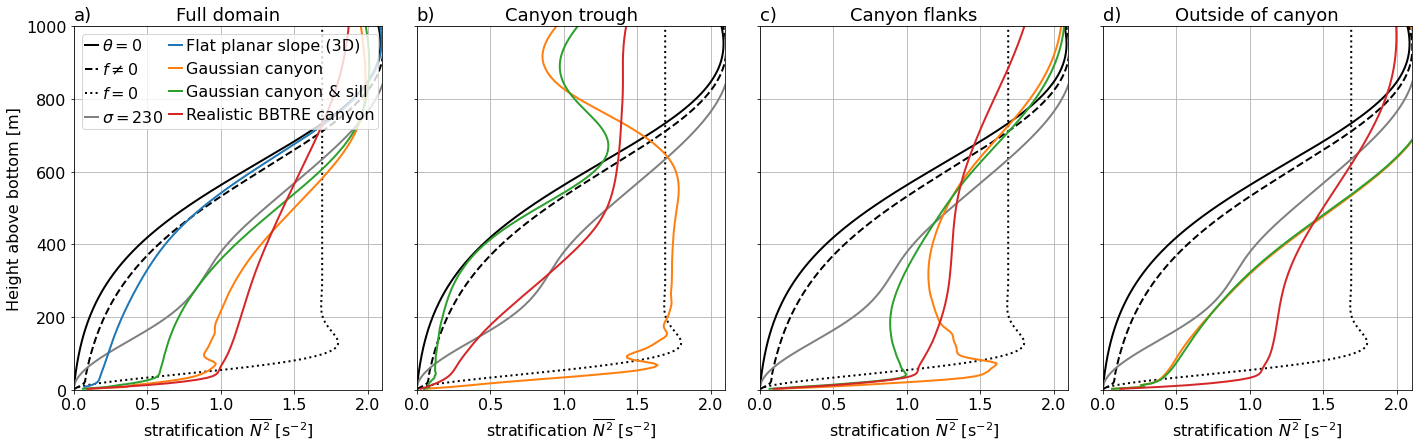

In [44]:
fig, axes = plt.subplots(1, 4, figsize=(20, 6.5))

expcolors = {
    'canyon-tracer': "C3",
    'idealized-sill': "C2",
    'idealized-canyon': "C1",
    'idealized-plane': "C0"
}
titles = ['Full domain', 'Canyon trough', 'Canyon flanks', 'Outside of canyon']
labels = ['a)', 'b)', 'c)', 'd)']
Nsq_names = ["", "_trough", "_flanks", "_outside"]

for i, ax in enumerate(axes):
    bbl_output['theta=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='-', label=r"$\theta = 0$", lw=2.)
    bbl_output['default']['bz'].plot(ax=ax, y='Zl', color="k", linestyle='--', label=r"$f\neq0$", lw=2.)
    bbl_output['f=0']['bz'].plot(ax=ax, y='Zl', color="k", linestyle=':', label=r"$f=0$", lw=2.)
    bbl_output['Pr=230']['bz'].plot(ax=ax, y='Zl', color="grey", label=r"$\sigma=230$", lw=2.)
    for exp in experiments:
        if (exp=='idealized-plane-1D'): continue
        if (exp=='idealized-plane') & (i>0): continue
        ds = data[exp]
        ds[f'Nsq{Nsq_names[i]}'].plot(ax=ax, y='habC', label=longnames[exp], color=expcolors[exp], lw=2.)
    ticks = np.arange(0., 2.5, 0.5)
    ax.set_xticks(ticks*1.e-6)
    ax.set_xticklabels(ticks)
    if i==0:
        ax.legend(loc='upper left', ncol=2, handlelength=0.8, columnspacing=0.4, borderpad=0.2, handletextpad=0.25)
        ax.set_ylabel("Height above bottom [m]")
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    ax.set_xlabel("stratification $\overline{N^{2}}$ [s$^{-2}$]")
    ax.set_ylim(0, 1000)
    ax.set_xlim([0, 2.1e-6])
    ax.grid(True)
    ax.set_title(titles[i], fontsize=18)
    ax.set_title(labels[i], loc='left', fontsize=18)
plt.tight_layout(w_pad=-2.5)
plt.savefig(f"../../figures/BBTRE/hab_stratification.png", dpi=150., bbox_inches="tight")